In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering; Aggregation; information fishing

We look at some categorical features and observe their distribution against sale price


In [2]:
raw_train = pd.read_csv('./res/train.csv')
raw_test = pd.read_csv('./res/test.csv')
sale_price = raw_train['SalePrice']
raw_train.drop(['SalePrice'], axis = 1, inplace=True)
raw_data = pd.concat((raw_train, raw_test))

In [3]:
raw_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


'Alley' is a feature for which NAs mean No_Alley_Access, we may impute every missing value right of the bat: 

In [4]:
# Imputing NA's in Alley

for df in [raw_data, raw_train, raw_test]:
    new_col = []
    for elt in df['Alley']:
        if not isinstance(elt, str):
            # NA
            new_col.append('No_Alley_Access')
        else:
            new_col.append(elt)
    df.loc[:, ['Alley']] = new_col

Potential new features:
- Has_Basement X
- Has_Porch X
- Has_Fireplace (see Fireplaces below) X
- Fireplaces : Zero, One or Two_or_more X (kept Fireplaces and tossed FireplaceQu)
- Has_garage X (kept GarageCars, tossed everything else)
- Condition1 & Condition2: most samples have Norm on both; can we do 'both_norm' and 'one_below_norm' and 'both_below_norm' X (True is both norm False otherwise)
- BldgType: 1Fam vs Not_1Fam X
- HouseStyle: 1_or_2_story vs other X
- Heating: GasA_or_GasW or other X


these below need study against SalePrice:
- Neighbourhood : check whether we can lower cardinality of categories by encoding the target variable
- OverallQual : check against sale price, but 5_to_7, 8_to_10, 4, below_4 looks appropriate given the univariate distribution
- OverallCond: same as above but with 4_or_below, 5, 6_or_7, 8_or_higher
- YearBuilt : groupby decade and observe sale price
- MasVnrArea, MasVnrType : swap to just 'Has_MasVnr'
- 1stFlrSF / 2ndFlrSF: ratio of TotalSF between 1st and 2nd SF
- LowQualityFinSF : Zero or Some 
- KitchenAboveGr : One or Zero or 2_or_more
- TotRmsAbvGrd: obeserbe bivariate vs SalePrice
- Functional: Type or Below_Par


Meta rule:
- make a list of key words in all feature names
- find the one amongst each keyword family that is most relevant ? or find most relevant families ?

In [5]:
def get_feature_family(keyword: str, dataset: pd.DataFrame)->np.array:
    feature_family = [col for col in dataset.columns if keyword in col]
    return np.array(feature_family)

In [6]:
# BSMT
# define a keyword to find all related features
# dict which keys are the keywords and values are the 
keyword = 'Bsmt'
keep = ['TotalBsmtSF']


feature_family = get_feature_family(keyword, raw_data)
# once I know all related features, either remove them and replace by 'Has_'keyword
for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)

In [7]:
# PORCH

# sum all Porch features to obtain TotalPorchSF
keyword = 'Porch'
feature_family = get_feature_family(keyword, raw_data)
# once I know all related features, either remove them and replace by 'Has_'keyword
total_porch_SF = raw_data[feature_family].sum(axis = 1)
for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)
raw_data['PorchTotalSF'] = total_porch_SF


In [8]:
# FIREPLACES
keyword = 'Fireplace'
feature_family = get_feature_family(keyword, raw_data)
keep = 'Fireplaces'

for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)


In [9]:
# GARAGE
keyword = 'Garage'
feature_family = get_feature_family(keyword, raw_data)
keep = 'GarageCars'

for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)

In [10]:
# CONDITION1 & CONDITION2
keyword = 'Condition'
feature_family = get_feature_family(keyword, raw_data)

condition1_norm = [elt == 'Norm' for elt in raw_data['Condition1']]
condition2_norm = [elt == 'Norm' for elt in raw_data['Condition2']]
proximity_condition = [cond1 and cond2 for cond1, cond2 in zip(condition1_norm, condition2_norm)]

raw_data['ProxCondition_Norm'] = proximity_condition
for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)

In [11]:
# BLDGTYPE
keyword = 'BldgType'
feature_family = get_feature_family(keyword, raw_data)

bld_type_is_1Fam = [elt == '1Fam' for elt in raw_data[keyword]]
for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)
raw_data['BldgType_Is_1Fam'] = bld_type_is_1Fam


In [12]:
# HOUSESTYLE
keyword = 'HouseStyle'
feature_family = get_feature_family(keyword, raw_data)

not_1_or_2_story = [elt != '1Story' and elt != '2Story' for elt in raw_data[keyword]]
raw_data.loc[not_1_or_2_story, [keyword]] = 'Other'

In [13]:
# HEATING
keyword = 'Heating'
feature_family = get_feature_family(keyword, raw_data)

heating_is_gasA = [elt == 'GasA' for elt in raw_data[keyword]]
raw_data['Heating_Is_GasA'] = heating_is_gasA

heatingQC_is_ok = [elt == 'Ex' or elt == 'Good' or elt == 'TA' for elt in raw_data['HeatingQC']]
raw_data['HeatingQC_Is_OK'] = heatingQC_is_ok

for ft in feature_family:
    if ft not in keep:
        raw_data.drop(ft, axis = 1, inplace = True)

Bivariate analysis of all features against SalePrice

In [14]:
raw_data.drop('Id', axis = 1, inplace = True)
raw_train = raw_data.iloc[:raw_train.shape[0], : ]
raw_train.loc[:, ['SalePrice']] = sale_price

KeyboardInterrupt: 

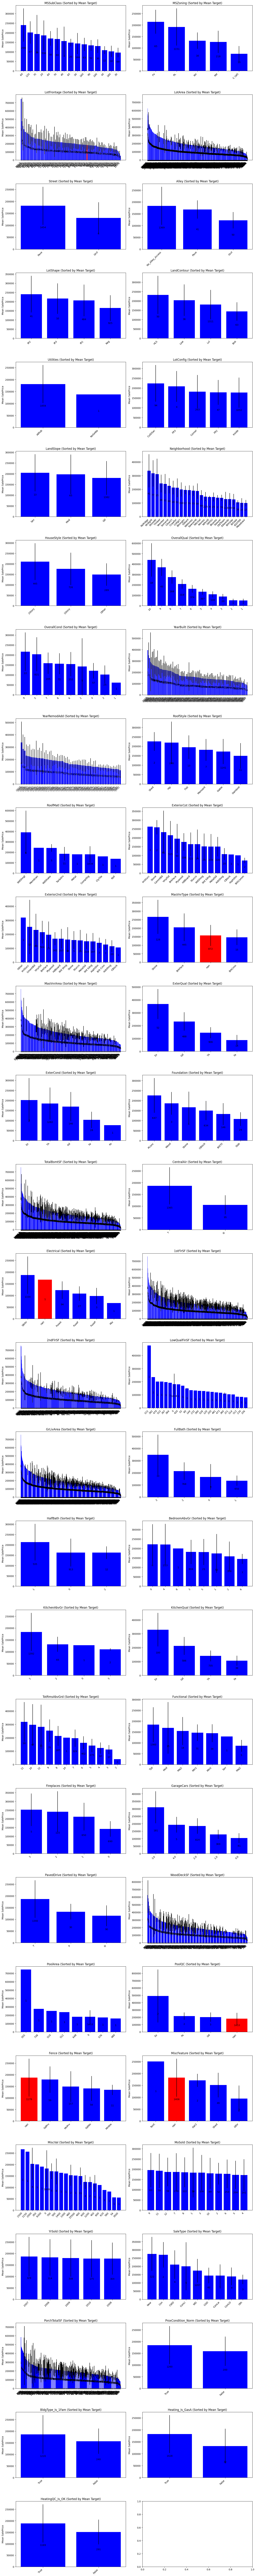

In [15]:
# Create a figure with 29 rows and 2 columns
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(15, 150))
axes = axes.flatten()  # Flatten to easily index each subplot

for i, feature in enumerate(raw_train.columns):
    if feature != 'SalePrice':
        # Compute the required statistics
        ft_price_mean = raw_train.groupby(feature, dropna=False).mean(numeric_only=True)['SalePrice'].sort_values(ascending=False)
        ft_price_std = raw_train.groupby(feature, dropna=False).std(numeric_only=True)['SalePrice']
        ft_count = raw_train.groupby(feature, dropna=False).count()['SalePrice']

        # Ensure indices are strings for consistency
        ft_price_mean.index, ft_price_std.index, ft_count.index = ft_price_mean.index.map(str), ft_price_std.index.map(str), ft_count.index.map(str)

        card = len(ft_price_mean)

        # Plot the data on the corresponding axis
        ax = axes[i]
        bar_colors = ['red' if label == 'nan' else 'blue' for label in ft_price_mean.index]
        bars = ax.bar(range(card), ft_price_mean, yerr=ft_price_std[ft_price_mean.index], color=bar_colors)

        ax.bar_label(bars, labels=ft_count[ft_price_mean.index], label_type='center')

        ax.set_ylabel('Mean SalePrice')
        ax.set_title(f'{feature} (Sorted by Mean Target)')
        ax.set_xticks(range(card))
        ax.set_xticklabels(ft_price_mean.index, rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./out/Feature_Target_Bivariate_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()


Comments:
- NAs need to be their own category (Alley for instance where it means 'no alley access')
- Continuous features reveal the existence of big outliers in SalePrice at the top end of the range (such as LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, WoodDeckSF, PorchTotalSF)
    - could be a move to explain their outlierness thanks to other categorical features to try and pick up on it in the test set
    - failing that; remove them from training
    
- RoofMatl: remove (no clear pattern to SalePrice given distribution of sample)
- MiscVal: remove
- MoSold : remove
- YrSold:: remove
- LowQualFinSF: remove
- BedroomAbvGr: remove
- KitchenAbvGr: remove
- Functional: remove
- PoolArea, PoolQC : remove
- Fence, MiscFeature : remove
- Exterior2nd: Other_to_BrkFace, Plywood_to_WdSdng, AsphShn_to_CBlock (removed)

- MSZoning: FV_or_RL, RH_or_RM, other X
- LotConfig : CulDSac_or_FR3, Other X
- OverallQual : 10_to_7, 6_or_lower X
- OverallCond: 9_or_5, 7_or_8_or_6, Other X
- MasVnrType: combine nan and BrkCmn X
- ExterCond: Ex_or_TA_or_Gd, Below_par X
- Foundation: PConc, Wood_or_Stone_or_CBlock, BrkTil_or_Slab X
- Electrical: SBrkr or Other X
- FullBath: 0_or_1, 2, 3 X
- HalfBath: 0 or 1_or_2 X
- Fireplaces: True or False X
- GarageCars: 3_or_More, 2, 1_or_less X
- PavedDrive: Y, P_or_N X
- SaleType : New, Other X
- Neighborhood : NoRidge_or_NridgeHt_or_StoneBr, Timber_to_SawyerW, Mitchell_to_BrkSide, BrVale_to_MeadowV (in mean saleprice order) X
- Exterior1st: ImStucc_or_Stone, HBoard_to_MetalSd, AsbsShng_to_BrkComm, rest as is X

- TotRmsAbvGrd: 9_or_more, 8_or_less (UNSURE)

In [16]:
features_to_remove= [
    'RoofMatl',
    'LowQualFinSF',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'Functional',
    'PoolArea',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'MiscVal',
    'MoSold',
    'YrSold',
    'Exterior2nd',
    'YearRemodAdd',
    'YearBuilt'
]

for ft in features_to_remove:
    raw_data.drop(ft, axis = 1, inplace = True)

for ft in features_to_remove:
    raw_train.drop(ft, axis = 1, inplace = True)

for ft in features_to_remove:
    raw_test.drop(ft, axis = 1, inplace = True)

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/1984160280.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_train.drop(ft, axis = 1, inplace = True)
/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/1984160280.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_train.drop(ft, axis = 1, inplace = True)
/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/1984160280.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [17]:
def categorize_NA(feature: str, dataset: pd.DataFrame, inpalce:bool = False)->list:
    if is_numeric_dtype(dataset[feature]) or dataset[feature].isna().sum()==0 :
        if inpalce:
            return None
        else:
            return dataset[feature]
    # if we are here then we are not numeric so we swap NAs to categorical NA
    new_col = []
    for elt in dataset[feature]:
        if not isinstance(elt, str):
            # We are in presence of a NaN :)
            new_col.append('NA')
        else:
            new_col.append(elt)
    if inpalce:
        dataset.loc[:, [feature]] = new_col
    return new_col

In [18]:
def recategorize(feature, cat_map, dataset):
    # cat_map is a dict like object whose keys are the old categories and whose values are the new categories
    new_col = []
    for elt in dataset[feature]:
        if elt in cat_map:
            new_col.append(cat_map[elt])
        else:
            new_col.append(elt)
    
    return new_col

In [19]:
# MSZoning
ft = 'MSZoning'
cat_map = {
    'FV': 'FV_or_RL',
    'RL': 'FV_or_RL',
    'RH': 'RH_or_RM',
    'RM': 'RH_or_RM',
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col


In [20]:
# LotConfig
ft = 'LotConfig'
cat_map = {
    'CulDSac': 'CulDSac_or_FR3',
    'FR3': 'CulDSac_or_FR3',
    'Corner': 'Other',
    'FR2': 'Other',
    'Inside': 'Other'
}
categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [21]:
# LotConfig
ft = 'LotConfig'
cat_map = {
    'CulDSac': 'CulDSac_or_FR3',
    'FR3': 'CulDSac_or_FR3',
    'Corner': 'Other',
    'FR2': 'Other',
    'Inside': 'Other'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [22]:
# OverallQual
ft = 'OverallQual'
cat_map = {
    10: '10_or_9',
    9: '10_or_9',
    4: '4_or_3',
    3: '4_or_3',
    2: '1_or_2',
    1: '1_or_2',
    5: '5',
    6: '6',
    7:'7',
    8:'8'

}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/48963466.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['7', '6', '7', '7', '8', '5', '8', '7', '7', '5', '5', '10_or_9', '5', '7', '6', '7', '6', '4_or_3', '5', '5', '8', '7', '8', '5', '5', '8', '5', '8', '5', '4_or_3', '4_or_3', '5', '8', '5', '10_or_9', '8', '5', '5', '5', '4_or_3', '6', '5', '5', '5', '5', '10_or_9', '7', '8', '4_or_3', '5', '6', '6', '5', '10_or_9', '5', '6', '8', '7', '10_or_9', '5', '6', '5', '8', '7', '7', '8', '7', '7', '4_or_3', '7', '7', '4_or_3', '7', '5', '4_or_3', '4_or_3', '4_or_3', '5', '4_or_3', '5', '6', '6', '8', '5', '7', '8', '6', '6', '4_or_3', '4_or_3', '4_or_3', '5', '5', '6', '6', '6', '7', '4_or_3', '5', '4_or_3', '6', '6', '5', '7', '7', '8', '4_or_3', '5', '5', '6', '6', '7', '7', '6', '6', '6', '5', '5', '7', '6', '6', '4_or_3', '6', '6', '6', '6', '6', '5', '6', '5', '7', '6', '5', '8', '5', '7', '

In [23]:
# OverallCond
ft = 'OverallCond'
cat_map = {
    9: '9_or_5',
    5: '9_or_5',
    7: '7_or_8_or_6',
    8: '7_or_8_or_6',
    6: '7_or_8_or_6',
    2: '2_or_4_or_3_or_1',
    4: '2_or_4_or_3_or_1',
    3: '2_or_4_or_3_or_1',
    1: '2_or_4_or_3_or_1',

}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/2164821236.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['9_or_5', '7_or_8_or_6', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '9_or_5', '9_or_5', '7_or_8_or_6', '9_or_5', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '9_or_5', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '2_or_4_or_3_or_1', '7_or_8_or_6', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '9_or_5', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '7_or_8_or_6', '7_or_8_or_6', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '7_or_8_or_6', '7_or_8_or_6', '7_or_8_or_6', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '9_or_5', '7_or_8_or_6', '9_or_5', '9_or_5',

In [24]:
# MasVnrType
ft = 'MasVnrType'

cat_map = {
    'NA': 'BrkCmn'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [25]:
# ExterCond
ft = 'ExterCond'

cat_map = {
    'Ex': 'Ex_or_TA_or_Gd',
    'TA': 'Ex_or_TA_or_Gd',
    'Gd': 'Ex_or_TA_or_Gd',
    'Fa': 'Below_par',
    'Po': 'Below_par'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [26]:
# Foundation
ft = 'Foundation'

cat_map = {
    'PConc': 'PConc_or_Wood',
    'Wood': 'PConc_or_Wood',
    'Stone': 'Stone_or_CBlock',
    'CBlock': 'Stone_or_CBlock',
    'BrkTil': 'BrkTil',
    'Slab': 'Slab'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [27]:
# Electrical
ft = 'Electrical'

cat_map = {
    'SBrkr': 'SBrkr',
    'NA': 'Other',
    'FuseA': 'Other',
    'FuseF': 'Other',
    'FuseP': 'Other',
    'Mix': 'Other'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [28]:
# FullBath
ft = 'FullBath'

cat_map = {
    3: '3',
    2: '2',
    0: '0_or_1',
    1: '0_or_1',
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/482523603.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2', '2', '2', '0_or_1', '2', '0_or_1', '2', '2', '2', '0_or_1', '0_or_1', '3', '0_or_1', '2', '0_or_1', '0_or_1', '0_or_1', '2', '0_or_1', '0_or_1', '3', '0_or_1', '2', '0_or_1', '0_or_1', '2', '0_or_1', '2', '0_or_1', '0_or_1', '0_or_1', '0_or_1', '2', '0_or_1', '2', '3', '0_or_1', '0_or_1', '0_or_1', '2', '2', '0_or_1', '0_or_1', '0_or_1', '0_or_1', '2', '0_or_1', '2', '2', '0_or_1', '2', '0_or_1', '0_or_1', '0_or_1', '0_or_1', '2', '2', '2', '3', '0_or_1', '0_or_1', '0_or_1', '2', '2', '2', '2', '2', '2', '0_or_1', '2', '2', '0_or_1', '2', '0_or_1', '2', '0_or_1', '0_or_1', '0_or_1', '2', '0_or_1', '2', '2', '2', '0_or_1', '2', '2', '2', '2', '0_or_1', '0_or_1', '0_or_1', '0_or_1', '0_or_1', '2', '2', '2', '2', '0_or_1', '0_or_1', '0_or_1', '2', '2', '2', '2', '0_or_1', '2', '0_or_1', 

In [29]:
# HalfBath
ft = 'HalfBath'

cat_map = {
    2: '0_or_2',
    0: '0_or_2',
    1: '1',
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/540306885.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1', '0_or_2', '1', '0_or_2', '1', '1', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '1', '0_or_2', '1', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '0_or_2', '1', '1', '1', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '1', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', '1', '0_or_2', '0_or_2', '1', '1', '1', '1', '1', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '0_or_2', '1', 

In [30]:
# Fireplaces
ft = 'Fireplaces'

cat_map = {
    2: True,
    1: True,
    3: True,
    0: False
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/1803361478.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, False, True, True, False, False, False, False, True, True, True, False, True, False, False, True, True, False, False, False, True, True, False, False, False, False, True, False, True, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, True, True, False, True, False, False, False, False, False, False, False, True, False, True, False, True, True, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, False, True, True, False, False, False, True, False, True, True, True, True, True, True, False, True, True, True, False, False

In [31]:
# GarageCars
ft = 'GarageCars'

cat_map = {
    4: '4_or_2',
    2: '4_or_2',
    3: '3',
    0: '0',
    1: '1'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_8308/3166474689.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4_or_2', '4_or_2', '4_or_2', '3', '3', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '1', '1', '3', '1', '3', '1', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '1', '3', '1', '4_or_2', '4_or_2', '1', '3', '4_or_2', '3', '1', '1', '1', '1', '4_or_2', '4_or_2', '4_or_2', '3', '4_or_2', '4_or_2', '1', '0', '4_or_2', '1', '4_or_2', '1', '1', '4_or_2', '4_or_2', '3', '0', '1', '4_or_2', '4_or_2', '4_or_2', '3', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '3', '1', '4_or_2', '1', '4_or_2', '4_or_2', '4_or_2', '3', '4_or_2', '4_or_2', '1', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '1', '1', '1', '1', '0', '4_or_2', '1', '4_or_2', '3', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '0', '0', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '4_or_2', '1', '1', '0', '4_or_2', '4_or_2', '4_o

In [32]:
# PavedDrive
ft = 'PavedDrive'

cat_map = {
    'P': 'P_or_N',
    'N': 'P_or_N'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [33]:
# SaleType
ft = 'SaleType'

cat_map = {
    'New': 'New_or_Con',
    'Con': 'New_or_Con',
    'CWD': 'Other',
    'ConLi': 'Other',
    'COD': 'Other',
    'WD': 'Other',
    'ConLw': 'Other',
    'ConLD': 'Other',
    'Oth': 'Other'
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [34]:
# Neighborhood
ft = 'Neighborhood'

cat_map = {
    'NoRidge': 'Tier_1',
    'NridgHt': 'Tier_1',
    'StoneBr': 'Tier_1',
    'Timber': 'Tier_2',
    'Veenker': 'Tier_2',
    'Somerst': 'Tier_2',
    'ClearCr': 'Tier_2',
    'Crawfor': 'Tier_2',
    'CollgCr': 'Tier_2',
    'Somerst': 'Tier_2',
    'Blmngtn': 'Tier_2',
    'Gilbert': 'Tier_2',
    'NWAmes': 'Tier_2',
    'SawyerW': 'Tier_2',
    'Mitchel': 'Tier_3',
    'NAmes': 'Tier_3',
    'NPkVill': 'Tier_3',
    'SWISU': 'Tier_3',
    'Blueste': 'Tier_3',
    'Sawyer': 'Tier_3',
    'OldTown': 'Tier_3',
    'Edwards': 'Tier_3',
    'BrkSide': 'Tier_3',
    'BrDale': 'Tier_4',
    'IDOTRR': 'Tier_4',
    'MeadowV': 'Tier_4',
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)
    

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [35]:
# Exterior1st
ft = 'Exterior1st'

cat_map = {
    'ImStucc': 'ImStucc_or_Stone',
    'Stone': 'ImStucc_or_Stone',
    'CementBd': 'CementBd',
    'VinylSd': 'VinylSd',
    'BrkFace': 'BrkFace',
    'Plywood': 'Plywood',
    'HdBoard': 'HBoard_to_MetalSd',
    'Stucco': 'HBoard_to_MetalSd',
    'WdShing': 'HBoard_to_MetalSd',
    'Wd Sdng': 'HBoard_to_MetalSd',
    'MetalSd': 'HBoard_to_MetalSd',
    'AsbShng': 'AsbsShng_to_BrkComm',
    'CBlock': 'AsbsShng_to_BrkComm',
    'AsphShn': 'AsbsShng_to_BrkComm',
    'BrkComm': 'AsbsShng_to_BrkComm',
}

categorize_NA(ft, raw_data, inpalce=True)
categorize_NA(ft, raw_train, inpalce=True)
categorize_NA(ft, raw_test, inpalce=True)
    

# Train
new_col = recategorize(ft, cat_map, raw_train)
raw_train.loc[:, [ft]] = new_col

# Test
new_col = recategorize(ft, cat_map, raw_test)
raw_test.loc[:, [ft]] = new_col

# Full
new_col = recategorize(ft, cat_map, raw_data)
raw_data.loc[:, [ft]] = new_col

In [36]:
raw_test = raw_data.iloc[raw_train.shape[0]:, :]

In [37]:
raw_data.isna().sum()

MSSubClass              0
MSZoning                0
LotFrontage           486
LotArea                 0
Street                  0
Alley                   0
LotShape                0
LandContour             0
Utilities               2
LotConfig               0
LandSlope               0
Neighborhood            0
HouseStyle              0
OverallQual             0
OverallCond             0
RoofStyle               0
Exterior1st             0
MasVnrType              0
MasVnrArea             23
ExterQual               0
ExterCond               0
Foundation              0
TotalBsmtSF             1
CentralAir              0
Electrical              0
1stFlrSF                0
2ndFlrSF                0
GrLivArea               0
FullBath                0
HalfBath                0
KitchenQual             1
TotRmsAbvGrd            0
Fireplaces              0
GarageCars              1
PavedDrive              0
WoodDeckSF              0
SaleType                0
PorchTotalSF            0
ProxConditio

### For the ramining NaN values, we should impute them once they categorical features have been transofrmed to numerical

# Export the processed Dataset to csv

In [38]:
raw_train.to_csv('./res/processed_train.csv')
raw_test.to_csv('./res/processed_test.csv')

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors= 5, weights= 'distance')

# let's perform imputation on the whole dataset to improve accuracy of the NN algorithm:

x = imputer.fit_transform(raw_data)


In [ ]:
# Let's deal with the few remaining NaNs in the Training Set
# For the test, we will have to 

# For some features that have NaNs remaining, the best method will be to replace NaN with the interpolated continuous value of the target vs feature
# So:
# Plot target vs feature
# make moving average
# identify average of nans in feature
# find matching value through moving average

feature_list = [
    'LotFrontage',
    'MasVnrArea',
    'TotalBsmtSF',
    'KitchenQual',
    'GarageCars'

]

for feature in feature_list:
    tgt_values = raw_train.groupby(feature, dropna=False).mean(numeric_only=True)['SalePrice'].sort_values()
    if tgt_values.index.isna().sum()>0:
        na_tgt_avg = tgt_values.loc[tgt_values.index.isna()].values

        # now find the closest category in terms of avg tgt value
        closest_cat = abs(tgt_values - na_tgt_avg).sort_values().index[1]

        # change the nan cat to the closest cat:
        raw_train.loc[raw_train[feature].isna(), [feature]] = closest_cat




